## overturning circulation

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import cmocean as cm
from dask.distributed import Client

In [2]:
client = Client(n_workers=4)
client

Client Scheduler: tcp://127.0.0.1:41879 Dashboard: /proxy/34427/status,Cluster Workers: 4 Cores: 8 Memory: 34.36 GB


In [3]:
expt = '1deg_jra55_ryf_RCPcont'
session = cc.database.create_session('/scratch/e14/cy8964/access-om2/archive/databases/1deg_jra55_ryf_experiments.db')
start_time='2900-01-31'
end_time = '2910-01-01'

In [4]:
psi = cc.querying.getvar(expt,'ty_trans_rho',session, ncfile = 'ocean.nc', start_time = start_time, end_time = end_time)#.isel(time = np.arange(40,50))
#psi = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho',chunks={'potrho': None}, n=-10)
psi = psi.sum('grid_xt_ocean')

# ty_trans_nrho -> transport within temperature intervals 
# neutral_rho, neutral.
#

varlist = cc.querying.get_variables(session, expt)
if varlist['name'].str.contains('ty_trans_rho_gm').any():
    GM = True
    psiGM = cc.querying.getvar(expt,'ty_trans_rho_gm',session,start_time = start_time, end_time = end_time)#.isel(time = np.arange(40,50))
    psiGM = psiGM.sum('grid_xt_ocean')
else:
    GM = False

In [8]:
var = cc.querying.getvar(expt,'ty_trans_nrho',session,ncfile='ocean.nc', start_time = start_time, end_time = end_time)#.isel(time = np.arange(40,50))
var = cc.querying.getvar(expt,'ty_trans_nrho_gm',session,ncfile='ocean.nc', start_time = start_time, end_time = end_time)#.isel(time = np.arange(40,50))
var = cc.querying.getvar(expt,'ty_trans_nrho_submeso',session,ncfile='ocean.nc', start_time = start_time, end_time = end_time)#.isel(time = np.arange(40,50))

var.neutral

<xarray.DataArray 'neutral' (neutral: 74)>
array([-2.75, -2.25, -1.75, -1.25, -0.75, -0.25,  0.25,  0.75,  1.25,  1.75,
        2.25,  2.75,  3.25,  3.75,  4.25,  4.75,  5.25,  5.75,  6.25,  6.75,
        7.25,  7.75,  8.25,  8.75,  9.25,  9.75, 10.25, 10.75, 11.25, 11.75,
       12.25, 12.75, 13.25, 13.75, 14.25, 14.75, 15.25, 15.75, 16.25, 16.75,
       17.25, 17.75, 18.25, 18.75, 19.25, 19.75, 20.25, 20.75, 21.25, 21.75,
       22.25, 22.75, 23.25, 23.75, 24.25, 24.75, 25.25, 25.75, 26.25, 26.75,
       27.25, 27.75, 28.25, 28.75, 29.25, 29.75, 30.25, 30.75, 31.25, 31.75,
       32.25, 32.75, 33.25, 33.75])
Coordinates:
  * neutral  (neutral) float64 -2.75 -2.25 -1.75 -1.25 ... 32.75 33.25 33.75
Attributes:
    long_name:       neutral density
    units:           kg/m^3
    cartesian_axis:  Z
    positive:        down
    edges:           neutralrho_edges

In [5]:
rho = 1025 # mean density of sea-water in kg/m^3
psi = psi / (1e6*rho) # converts kg/s to Sv
if GM:
    psiGM = psiGM / (1e6*rho)

In [6]:
psi_avg_cont = psi.cumsum('potrho').mean('time') - psi.sum('potrho').mean('time')
if GM:
    psi_avg_cont = psi_avg_cont + psiGM.mean('time')
    
psi_avg_cont.load()

<xarray.DataArray (potrho: 74, grid_yu_ocean: 300)>
array([[ 0.        ,  0.00528678,  0.01151265, ...,  0.00240586,
         0.00119117, -0.00090009],
       [ 0.        ,  0.00528678,  0.01151265, ...,  0.00198541,
         0.00058815, -0.00139094],
       [ 0.        ,  0.00528678,  0.01151265, ...,  0.00107191,
        -0.00029782, -0.00188861],
       ...,
       [ 0.        ,  0.02239094,  0.01427874, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)
Coordinates:
  * grid_yu_ocean  (grid_yu_ocean) float64 -77.75 -77.51 -77.26 ... 89.55 90.0
  * potrho         (potrho) float64 1.028e+03 1.028e+03 ... 1.038e+03 1.038e+03

In [7]:
psi

<xarray.DataArray 'ty_trans_rho' (time: 10, potrho: 74, grid_yu_ocean: 300)>
dask.array<truediv, shape=(10, 74, 300), dtype=float32, chunksize=(1, 37, 150), chunktype=numpy.ndarray>
Coordinates:
  * time           (time) object 2900-07-02 12:00:00 ... 2909-07-02 12:00:00
  * grid_yu_ocean  (grid_yu_ocean) float64 -77.75 -77.51 -77.26 ... 89.55 90.0
  * potrho         (potrho) float64 1.028e+03 1.028e+03 ... 1.038e+03 1.038e+03

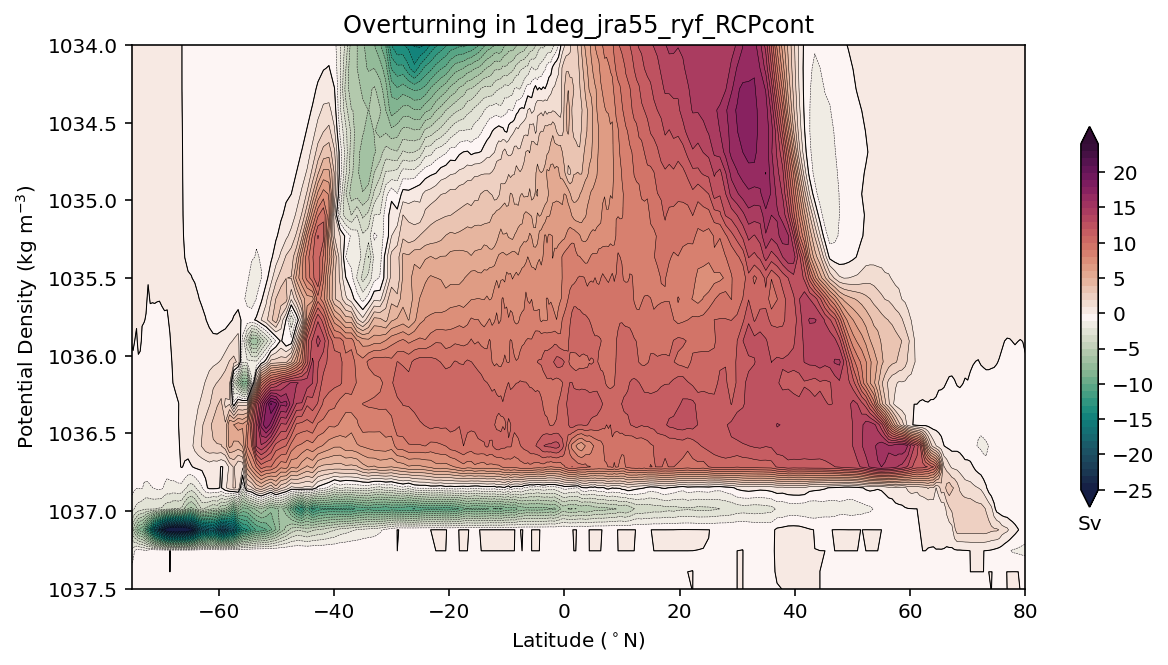

In [8]:
plt.figure(figsize=(10, 5)) 
clev = np.arange(-25,25,1)
plt.contourf(psi_avg_cont.grid_yu_ocean,psi_avg_cont.potrho, psi_avg_cont, cmap=cm.cm.curl, levels=clev, extend='both')
cb=plt.colorbar(orientation='vertical', shrink = 0.7)
    
cb.ax.set_xlabel('Sv')
plt.contour(psi_avg_cont.grid_yu_ocean, psi_avg_cont.potrho, psi_avg_cont, levels=clev, colors='k', linewidths=0.25)
plt.contour(psi_avg_cont.grid_yu_ocean, psi_avg_cont.potrho, psi_avg_cont, levels=[0.0,], colors='k', linewidths=0.5)
plt.gca().invert_yaxis()

plt.ylim((1037.5,1034))
plt.ylabel('Potential Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75,80])
plt.title('Overturning in %s' % expt);
plt.savefig('figures/overturning')

before 2900

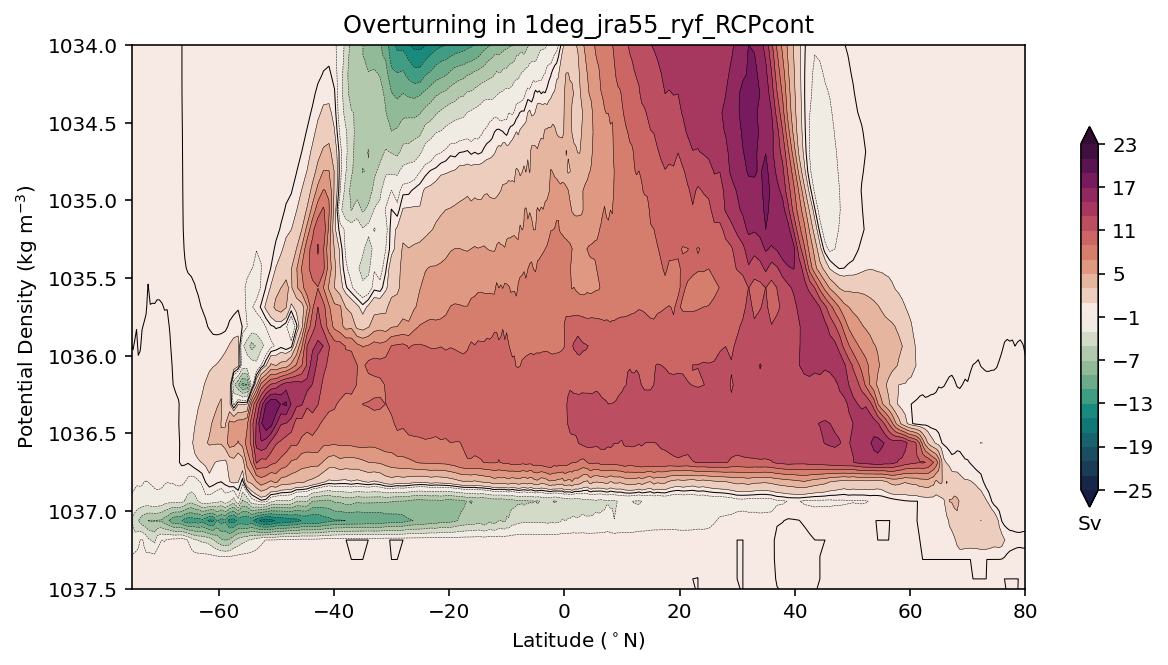

In [14]:
plt.figure(figsize=(10, 5)) 
clev = np.arange(-25,25,2)
plt.contourf(psi_avg_cont.grid_yu_ocean,psi_avg_cont.potrho, psi_avg_cont, cmap=cm.cm.curl, levels=clev, extend='both')
cb=plt.colorbar(orientation='vertical', shrink = 0.7)
    
cb.ax.set_xlabel('Sv')
plt.contour(psi_avg_cont.grid_yu_ocean, psi_avg_cont.potrho, psi_avg_cont, levels=clev, colors='k', linewidths=0.25)
plt.contour(psi_avg_cont.grid_yu_ocean, psi_avg_cont.potrho, psi_avg_cont, levels=[0.0,], colors='k', linewidths=0.5)
plt.gca().invert_yaxis()

plt.ylim((1037.5,1034))
plt.ylabel('Potential Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75,80])
plt.title('Overturning in %s' % expt);

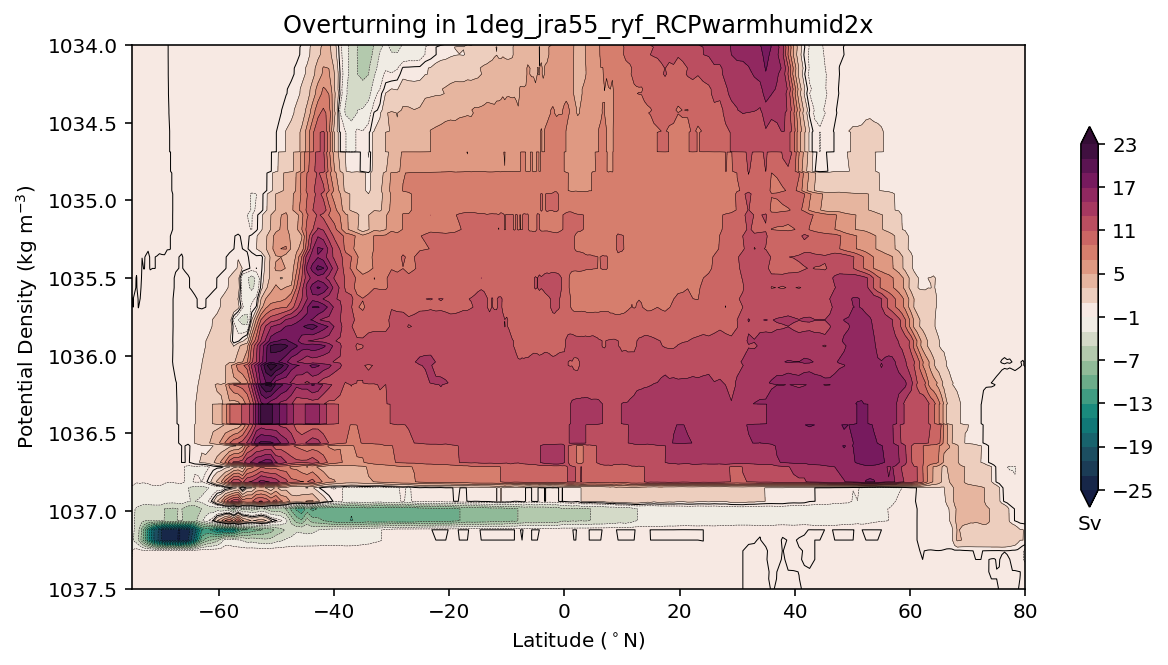

In [16]:
plt.figure(figsize=(10, 5)) 
clev = np.arange(-25,25,2)
plt.contourf(psi_avg_cont.grid_yu_ocean,psi_avg_cont.potrho, psi_avg_cont, cmap=cm.cm.curl, levels=clev, extend='both')
cb=plt.colorbar(orientation='vertical', shrink = 0.7)
    
cb.ax.set_xlabel('Sv')
plt.contour(psi_avg_cont.grid_yu_ocean, psi_avg_cont.potrho, psi_avg_cont, levels=clev, colors='k', linewidths=0.25)
plt.contour(psi_avg_cont.grid_yu_ocean, psi_avg_cont.potrho, psi_avg_cont, levels=[0.0,], colors='k', linewidths=0.5)
plt.gca().invert_yaxis()

plt.ylim((1037.5,1034))
plt.ylabel('Potential Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75,80])
plt.title('Overturning in %s' % expt);

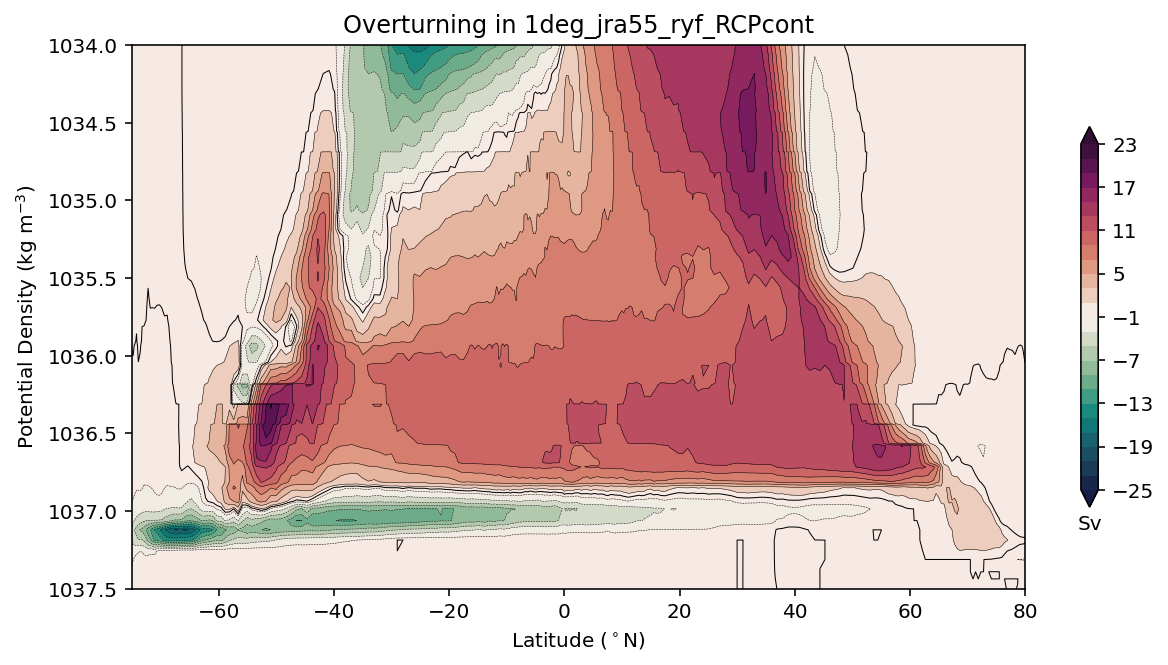

In [7]:
plt.figure(figsize=(10, 5)) 
clev = np.arange(-25,25,2)
plt.contourf(psi_avg_cont.grid_yu_ocean,psi_avg_cont.potrho, psi_avg_cont, cmap=cm.cm.curl, levels=clev, extend='both')
cb=plt.colorbar(orientation='vertical', shrink = 0.7)
    
cb.ax.set_xlabel('Sv')
plt.contour(psi_avg_cont.grid_yu_ocean, psi_avg_cont.potrho, psi_avg_cont, levels=clev, colors='k', linewidths=0.25)
plt.contour(psi_avg_cont.grid_yu_ocean, psi_avg_cont.potrho, psi_avg_cont, levels=[0.0,], colors='k', linewidths=0.5)
plt.gca().invert_yaxis()

plt.ylim((1037.5,1034))
plt.ylabel('Potential Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75,80])
plt.title('Overturning in %s' % expt);

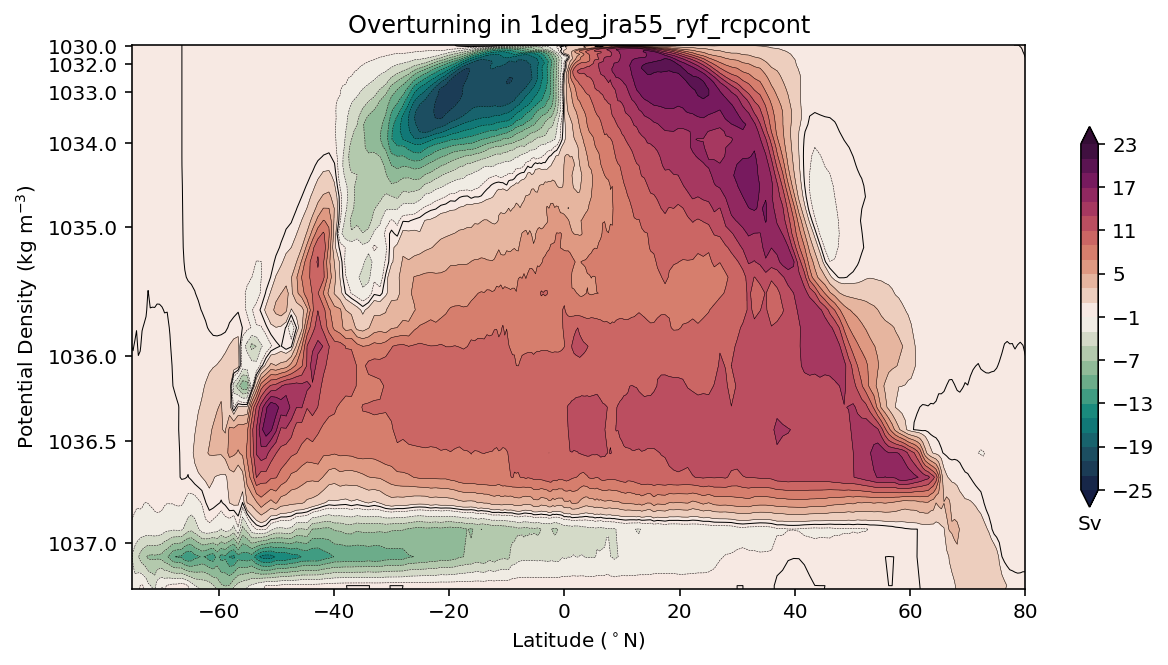

In [11]:
fig,ax = plt.subplots(1,1,figsize=(10, 5)) 
clev = np.arange(-25,25,2)
yticks = np.array([1030, 1032, 1033, 1034, 1035, 1036,1036.5, 1037])
scfac = 4  ## A power to set teh stretching
p1=ax.contourf(psi_avg_cont.grid_yu_ocean,(psi_avg_cont.potrho-1028)**scfac, psi_avg_cont, cmap=cm.cm.curl, levels=clev, extend='both')
cb=plt.colorbar(p1,orientation='vertical', shrink = 0.7)
    
cb.ax.set_xlabel('Sv')
ax.contour(psi_avg_cont.grid_yu_ocean,(psi_avg_cont.potrho-1028)**scfac, psi_avg_cont, levels=clev, colors='k', linewidths=0.25)
ax.contour(psi_avg_cont.grid_yu_ocean,(psi_avg_cont.potrho-1028)**scfac, psi_avg_cont, levels=[0.0,], colors='k', linewidths=0.5)

ax.set_yticks((yticks-1028)**scfac)
ax.set_yticklabels(yticks)
ax.set_ylim([0.5**scfac, 9.2**scfac])
ax.invert_yaxis()
ax.set_ylabel('Potential Density (kg m$^{-3}$)')
ax.set_xlabel('Latitude ($^\circ$N)')
ax.set_xlim([-75,80])
ax.set_title('Overturning in %s' % expt);

In [12]:
expt = '1deg_jra55_ryf_rcpcool'
session = cc.database.create_session('/scratch/e14/cy8964/access-om2/archive/databases/1deg_jra55_ryf_experiments.db')
start_time='2198-01-01'

psi = cc.querying.getvar(expt,'ty_trans_rho',session, ncfile = 'ocean.nc').isel(time = np.arange(0,20))
#psi = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho',chunks={'potrho': None}, n=-10)
psi = psi.sum('grid_xt_ocean')

varlist = cc.querying.get_variables(session, expt)
if varlist['name'].str.contains('ty_trans_rho_gm').any():
    GM = True
    psiGM = cc.querying.getvar(expt,'ty_trans_rho_gm',session,start_time = start_time).isel(time = np.arange(0,20))
    psiGM = psiGM.sum('grid_xt_ocean')
else:
    GM = False
    
rho = 1025 # mean density of sea-water in kg/m^3
psi = psi / (1e6*rho) # converts kg/s to Sv
if GM:
    psiGM = psiGM / (1e6*rho)
    
psi_avg_cool = psi.cumsum('potrho').mean('time') - psi.sum('potrho').mean('time')
if GM:
    psi_avg_cool = psi_avg_cool + psiGM.mean('time')
    
psi_avg_cool.load()

<xarray.DataArray (potrho: 80, grid_yu_ocean: 300)>
array([[ 0.        ,  0.00580906,  0.01245623, ..., -0.00784578,
        -0.00567433,  0.00063923],
       [ 0.        ,  0.00580906,  0.01245623, ..., -0.00659712,
        -0.00544811, -0.00158737],
       [ 0.        ,  0.00580906,  0.01245623, ..., -0.00697165,
        -0.00686568, -0.00191143],
       ...,
       [ 0.        ,  0.03871038,  0.03159666, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.00011273, -0.00048228, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)
Coordinates:
  * grid_yu_ocean  (grid_yu_ocean) float64 -77.75 -77.51 -77.26 ... 89.55 90.0
  * potrho         (potrho) float64 1.028e+03 1.028e+03 ... 1.038e+03 1.038e+03

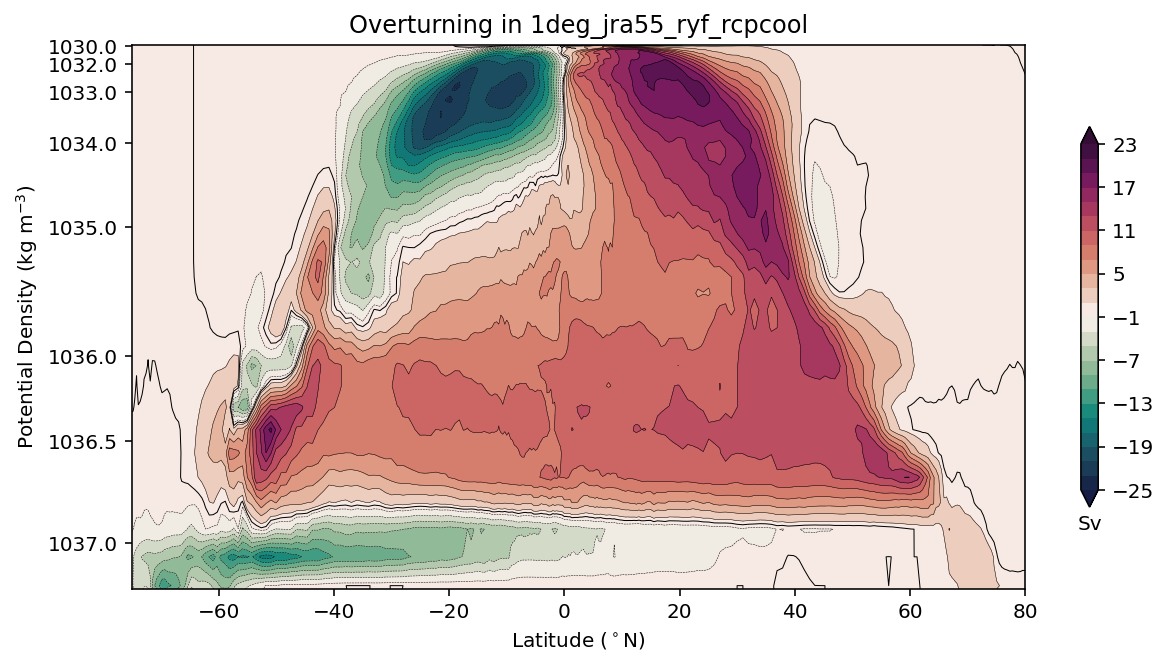

In [13]:
fig,ax = plt.subplots(1,1,figsize=(10, 5)) 
clev = np.arange(-25,25,2)
yticks = np.array([1030, 1032, 1033, 1034, 1035, 1036,1036.5, 1037])
scfac = 4  ## A power to set teh stretching
p1=ax.contourf(psi_avg_cool.grid_yu_ocean,(psi_avg_cool.potrho-1028)**scfac, psi_avg_cool, cmap=cm.cm.curl, levels=clev, extend='both')
cb=plt.colorbar(p1,orientation='vertical', shrink = 0.7)
    
cb.ax.set_xlabel('Sv')
ax.contour(psi_avg_cool.grid_yu_ocean,(psi_avg_cool.potrho-1028)**scfac, psi_avg_cool, levels=clev, colors='k', linewidths=0.25)
ax.contour(psi_avg_cool.grid_yu_ocean,(psi_avg_cool.potrho-1028)**scfac, psi_avg_cool, levels=[0.0,], colors='k', linewidths=0.5)

ax.set_yticks((yticks-1028)**scfac)
ax.set_yticklabels(yticks)
ax.set_ylim([0.5**scfac, 9.2**scfac])
ax.invert_yaxis()
ax.set_ylabel('Potential Density (kg m$^{-3}$)')
ax.set_xlabel('Latitude ($^\circ$N)')
ax.set_xlim([-75,80])
ax.set_title('Overturning in %s' % expt);

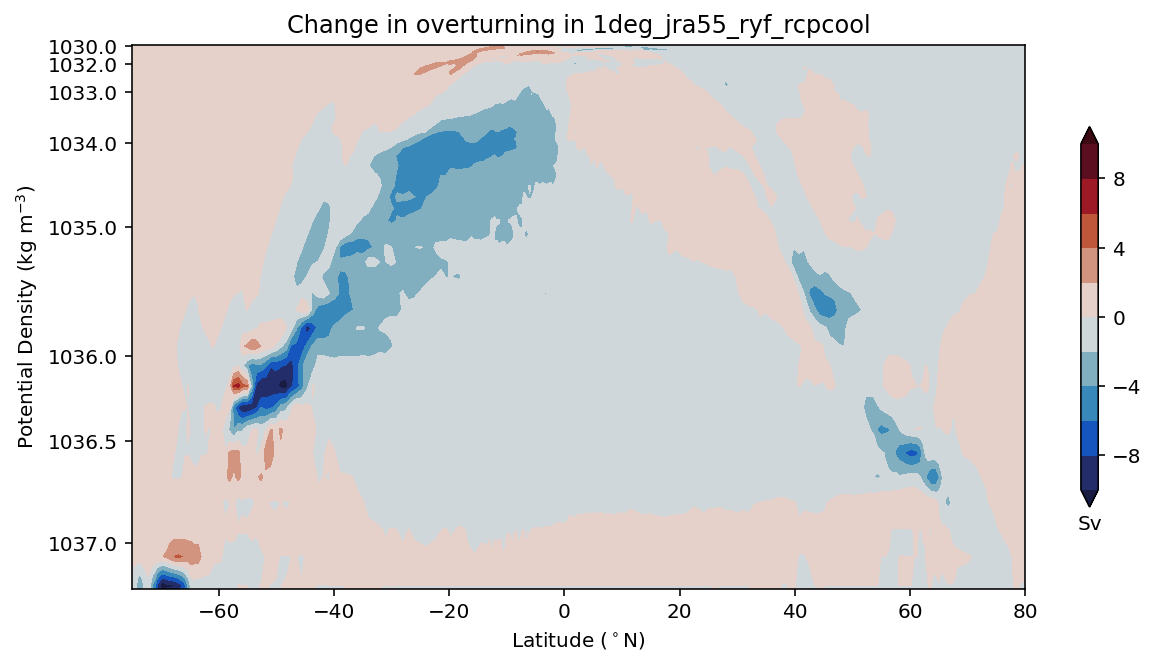

In [14]:
fig,ax = plt.subplots(1,1,figsize=(10, 5)) 
clev = np.arange(-10,12,2)
yticks = np.array([1030, 1032, 1033, 1034, 1035, 1036,1036.5, 1037])
scfac = 4  ## A power to set teh stretching
p1=ax.contourf((psi_avg_cool-psi_avg_cont).grid_yu_ocean,((psi_avg_cool-psi_avg_cont).potrho-1028)**scfac, (psi_avg_cool-psi_avg_cont), cmap=cm.cm.balance, levels=clev, extend='both')
cb=plt.colorbar(p1,orientation='vertical', shrink = 0.7)
    
cb.ax.set_xlabel('Sv')
#ax.contour((psi_avg_cool-psi_avg_cont).grid_yu_ocean,((psi_avg_cool-psi_avg_cont).potrho-1028)**scfac, (psi_avg_cool-psi_avg_cont), levels=clev, colors='k', linewidths=0.25)
#ax.contour((psi_avg_cool-psi_avg_cont).grid_yu_ocean,((psi_avg_cool-psi_avg_cont).potrho-1028)**scfac, (psi_avg_cool-psi_avg_cont), levels=[0.0,], colors='k', linewidths=0.5)

ax.set_yticks((yticks-1028)**scfac)
ax.set_yticklabels(yticks)
ax.set_ylim([0.5**scfac, 9.2**scfac])
ax.invert_yaxis()
ax.set_ylabel('Potential Density (kg m$^{-3}$)')
ax.set_xlabel('Latitude ($^\circ$N)')
ax.set_xlim([-75,80])
ax.set_title('Change in overturning in %s' % expt);

In [15]:
expt = '1deg_jra55_ryf_rcpwarm'
session = cc.database.create_session('/scratch/e14/cy8964/access-om2/archive/databases/1deg_jra55_ryf_experiments.db')
start_time='2198-01-01'

psi = cc.querying.getvar(expt,'ty_trans_rho',session, ncfile = 'ocean.nc').isel(time = np.arange(0,20))
#psi = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho',chunks={'potrho': None}, n=-10)
psi = psi.sum('grid_xt_ocean')

varlist = cc.querying.get_variables(session, expt)
if varlist['name'].str.contains('ty_trans_rho_gm').any():
    GM = True
    psiGM = cc.querying.getvar(expt,'ty_trans_rho_gm',session,start_time = start_time).isel(time = np.arange(0,20))
    psiGM = psiGM.sum('grid_xt_ocean')
else:
    GM = False
    
rho = 1025 # mean density of sea-water in kg/m^3
psi = psi / (1e6*rho) # converts kg/s to Sv
if GM:
    psiGM = psiGM / (1e6*rho)
    
psi_avg_warm = psi.cumsum('potrho').mean('time') - psi.sum('potrho').mean('time')
if GM:
    psi_avg_warm = psi_avg_warm + psiGM.mean('time')
    
psi_avg_warm.load()

<xarray.DataArray (potrho: 80, grid_yu_ocean: 300)>
array([[ 0.        ,  0.00470996,  0.01040913, ...,  0.01081664,
         0.0069667 ,  0.00149442],
       [ 0.        ,  0.00470996,  0.01040913, ...,  0.00945082,
         0.00460176, -0.00197669],
       [ 0.        ,  0.00470996,  0.01040913, ...,  0.00910037,
         0.00488615, -0.0024851 ],
       ...,
       [ 0.        ,  0.00021509,  0.00139562, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)
Coordinates:
  * grid_yu_ocean  (grid_yu_ocean) float64 -77.75 -77.51 -77.26 ... 89.55 90.0
  * potrho         (potrho) float64 1.028e+03 1.028e+03 ... 1.038e+03 1.038e+03

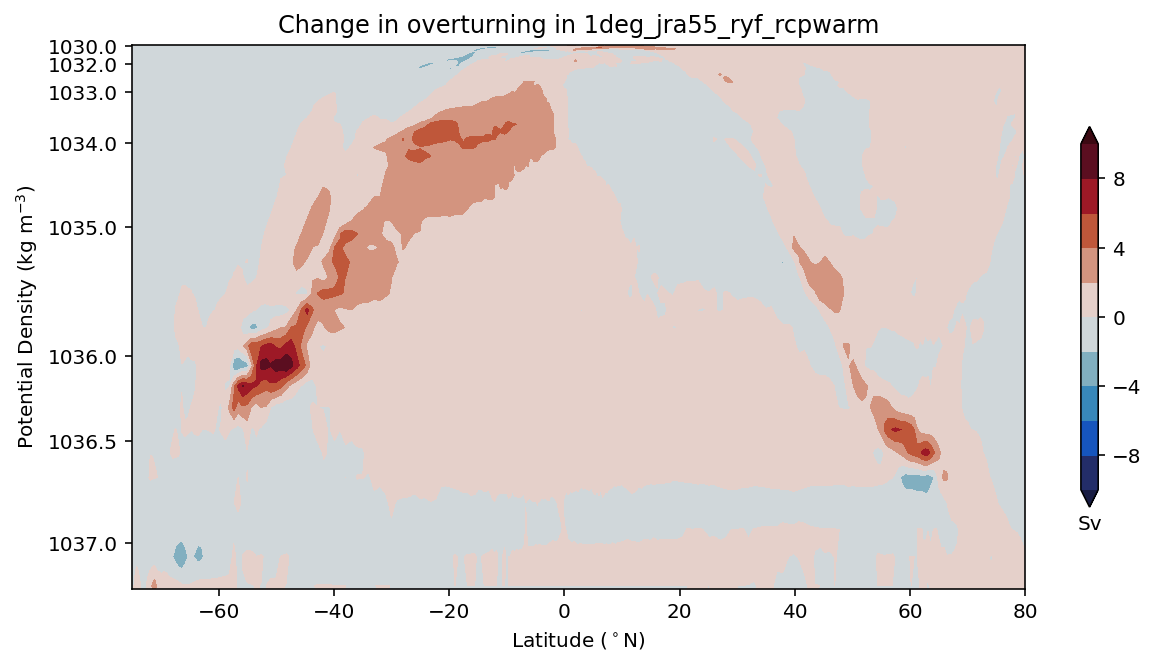

In [16]:
fig,ax = plt.subplots(1,1,figsize=(10, 5)) 
clev = np.arange(-10,12,2)
yticks = np.array([1030, 1032, 1033, 1034, 1035, 1036,1036.5, 1037])
scfac = 4  ## A power to set teh stretching
p1=ax.contourf((psi_avg_warm-psi_avg_cont).grid_yu_ocean,((psi_avg_warm-psi_avg_cont).potrho-1028)**scfac, (psi_avg_warm-psi_avg_cont), cmap=cm.cm.balance, levels=clev, extend='both')
cb=plt.colorbar(p1,orientation='vertical', shrink = 0.7)
    
cb.ax.set_xlabel('Sv')
#ax.contour((psi_avg_warm-psi_avg_cont).grid_yu_ocean,((psi_avg_warm-psi_avg_cont).potrho-1028)**scfac, (psi_avg_warm-psi_avg_cont), levels=clev, colors='k', linewidths=0.25)
#ax.contour((psi_avg_warm-psi_avg_cont).grid_yu_ocean,((psi_avg_warm-psi_avg_cont).potrho-1028)**scfac, (psi_avg_warm-psi_avg_cont), levels=[0.0,], colors='k', linewidths=0.5)

ax.set_yticks((yticks-1028)**scfac)
ax.set_yticklabels(yticks)
ax.set_ylim([0.5**scfac, 9.2**scfac])
ax.invert_yaxis()
ax.set_ylabel('Potential Density (kg m$^{-3}$)')
ax.set_xlabel('Latitude ($^\circ$N)')
ax.set_xlim([-75,80])
ax.set_title('Change in overturning in %s' % expt);



Notes:

    We have not included the submesoscale contribution to the meridional transport in these calculations, as it tends to be relatively unimportant for the deep circulation, which we where we are primarily interested.
    These metrics do not use mathematically correct zonal averaging in the tripole region, north of 65°N.



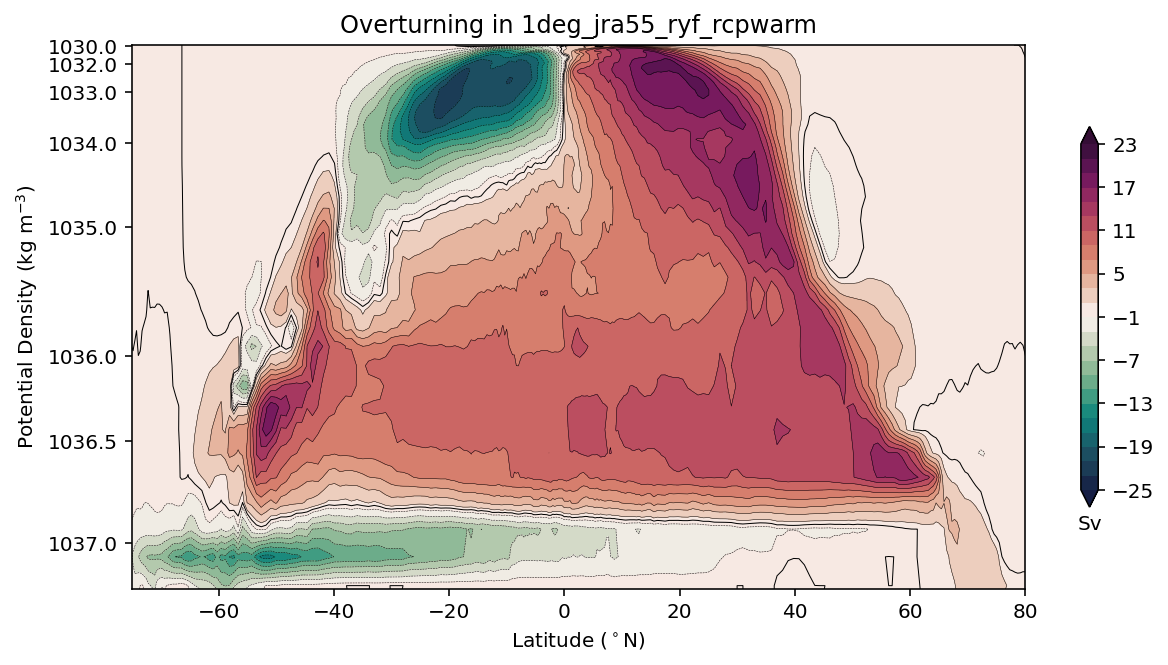

In [44]:
fig,ax = plt.subplots(1,1,figsize=(10, 5)) 
clev = np.arange(-25,25,2)
yticks = np.array([1030, 1032, 1033, 1034, 1035, 1036,1036.5, 1037])
scfac = 4  ## A power to set teh stretching
p1=ax.contourf(psi_avg_cont.grid_yu_ocean,(psi_avg_cont.potrho-1028)**scfac, psi_avg_cont, cmap=cm.cm.curl, levels=clev, extend='both')
cb=plt.colorbar(p1,orientation='vertical', shrink = 0.7)
    
cb.ax.set_xlabel('Sv')
ax.contour(psi_avg_cont.grid_yu_ocean,(psi_avg_cont.potrho-1028)**scfac, psi_avg_cont, levels=clev, colors='k', linewidths=0.25)
ax.contour(psi_avg_cont.grid_yu_ocean,(psi_avg_cont.potrho-1028)**scfac, psi_avg_cont, levels=[0.0,], colors='k', linewidths=0.5)

ax.set_yticks((yticks-1028)**scfac)
ax.set_yticklabels(yticks)
ax.set_ylim([0.5**scfac, 9.2**scfac])
ax.invert_yaxis()
ax.set_ylabel('Potential Density (kg m$^{-3}$)')
ax.set_xlabel('Latitude ($^\circ$N)')
ax.set_xlim([-75,80])
ax.set_title('Overturning in %s' % expt);